In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\Ultrasound Fetus Dataset\FetusDataset.csv")
target_col = 'fetal_health'
X = df.drop(columns=[target_col])
y_raw = df[target_col]
le = LabelEncoder()
y = le.fit_transform(y_raw)

X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

models = {}
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_estimators=100, n_jobs=1)
except Exception:
    models['XGBoost (sklearn fallback)'] = GradientBoostingClassifier(random_state=42, n_estimators=100)

models['RandomForest'] = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
models['DecisionTree'] = DecisionTreeClassifier(random_state=42)
models['LogisticRegression'] = LogisticRegression(max_iter=1000, multi_class='ovr', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'accuracy':'accuracy','precision':'precision_macro','recall':'recall_macro','f1':'f1_macro'}

results_cv = {}
for name, model in models.items():
    scores = cross_validate(model, X_scaled, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=1)
    results_cv[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

test_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        try:
            auc = roc_auc_score(pd.get_dummies(y_test), y_proba, average='macro')
        except Exception:
            auc = None
    else:
        auc = None
    test_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'auc_macro_ovr': auc,
        'classification_report': classification_report(y_test, y_pred, digits=4, target_names=[str(c) for c in le.classes_])
    }

import pprint
print("Label mapping (original -> encoded):")
pprint.pprint(dict(zip(le.classes_, le.transform(le.classes_))))
print("\nCross-validation (5-fold Stratified) mean scores:")
pprint.pprint(results_cv)
print("\nTest set results:")
for name, res in test_results.items():
    print(f"\n=== {name} ===")
    print("Accuracy:", res['accuracy'])
    print("Precision (macro):", res['precision'])
    print("Recall (macro):", res['recall'])
    print("F1 (macro):", res['f1'])
    print("AUC (macro, OVR):", res['auc_macro_ovr'])
    print("Classification report:\n", res['classification_report'])


Label mapping (original -> encoded):
{np.float64(1.0): np.int64(0),
 np.float64(2.0): np.int64(1),
 np.float64(3.0): np.int64(2)}

Cross-validation (5-fold Stratified) mean scores:
{'DecisionTree': {'accuracy': np.float64(0.9125103562551781),
                  'f1': np.float64(0.8562849143349739),
                  'precision': np.float64(0.8545382963210016),
                  'recall': np.float64(0.8602845476581971)},
 'LogisticRegression': {'accuracy': np.float64(0.896051919359293),
                        'f1': np.float64(0.796746043915319),
                        'precision': np.float64(0.8213490649355437),
                        'recall': np.float64(0.7792916706967605)},
 'RandomForest': {'accuracy': np.float64(0.9468434134217067),
                  'f1': np.float64(0.9000481336434779),
                  'precision': np.float64(0.9236082481894297),
                  'recall': np.float64(0.8812214259569474)},
 'XGBoost': {'accuracy': np.float64(0.951549295774648),
             'f

Label mapping (original -> encoded):

np.float64(1.0): np.int64(0), : Normal

 np.float64(2.0): np.int64(1),: Benign
 
 np.float64(3.0): np.int64(2),: Malignant

In [ ]:
print(np.unique(y)) 

[0 1 2]


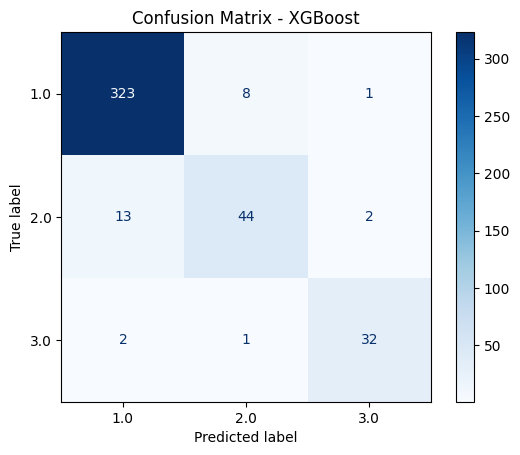

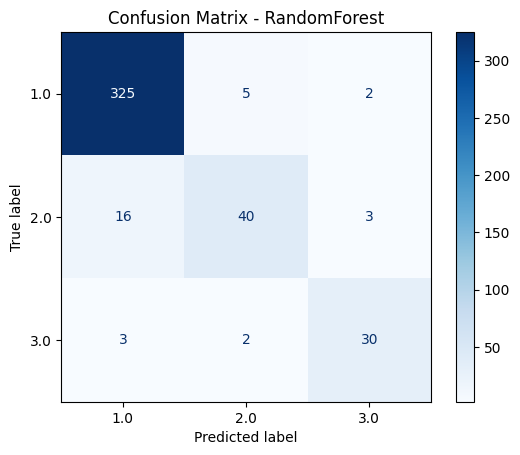

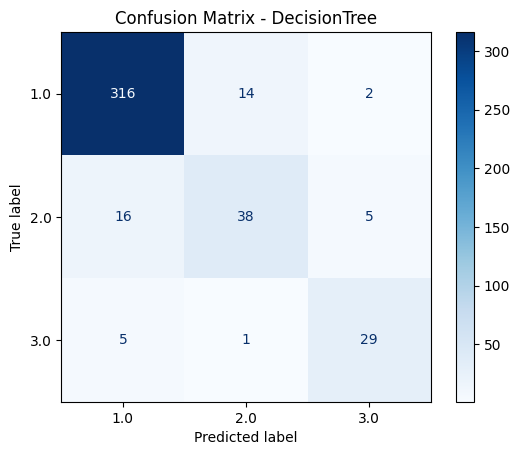

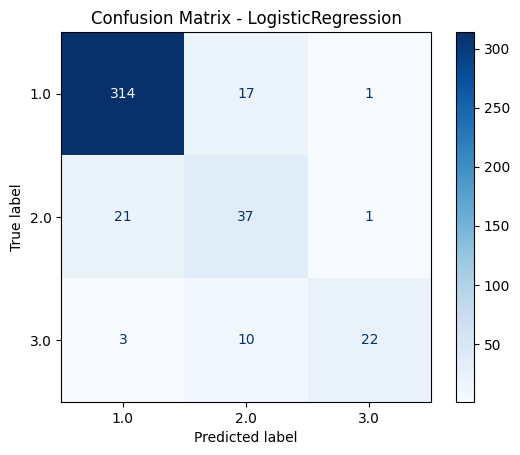

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=le.classes_, cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


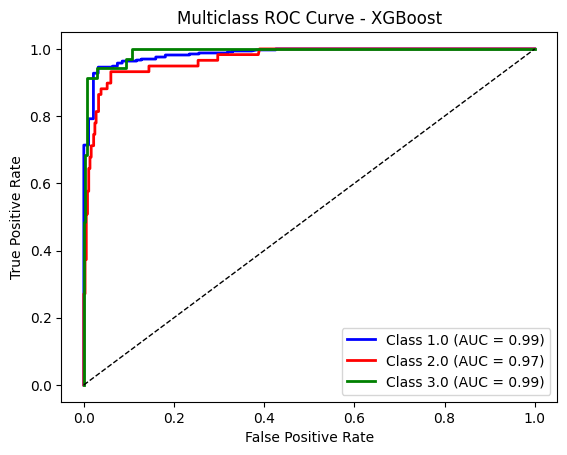

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_bin.shape[1]
y_score = models['XGBoost'].predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()


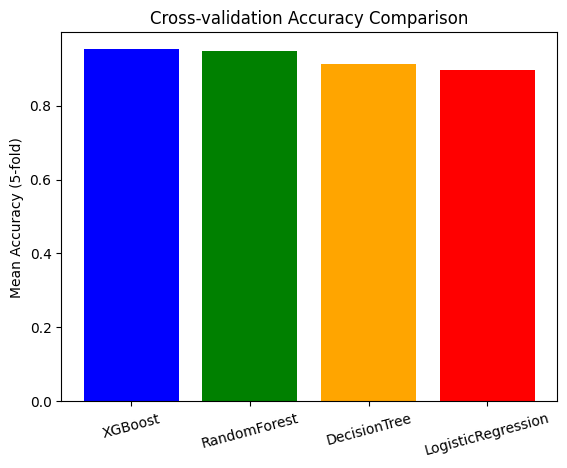

In [4]:
import matplotlib.pyplot as plt

cv_scores = [results_cv[m]['accuracy'] for m in results_cv]
plt.bar(results_cv.keys(), cv_scores, color=['blue','green','orange','red'])
plt.title("Cross-validation Accuracy Comparison")
plt.ylabel("Mean Accuracy (5-fold)")
plt.xticks(rotation=15)
plt.show()


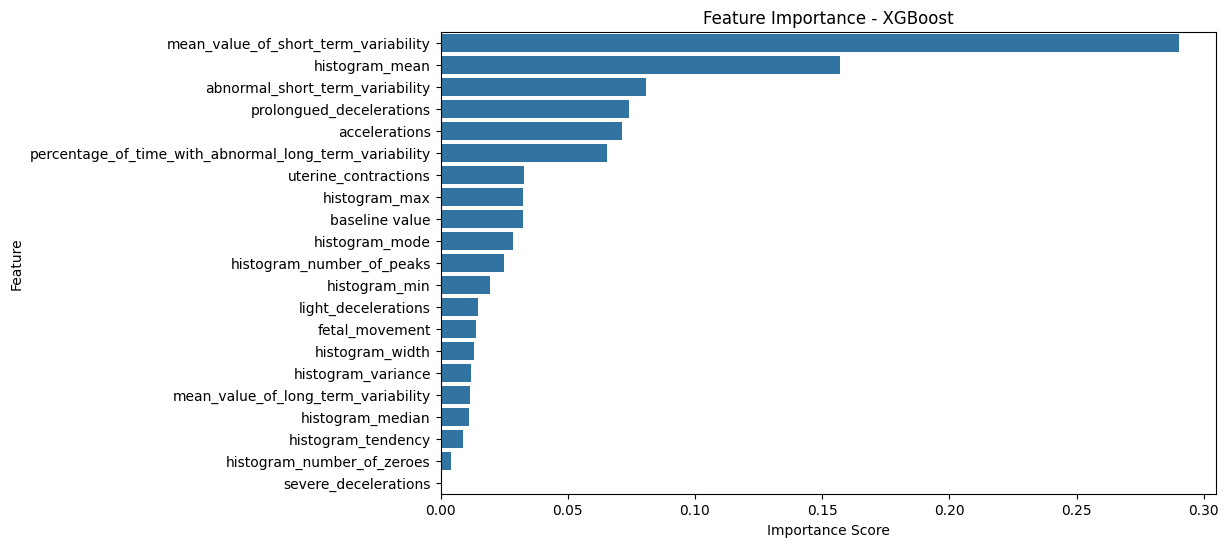

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model = models['XGBoost']
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=np.array(X.columns)[indices])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


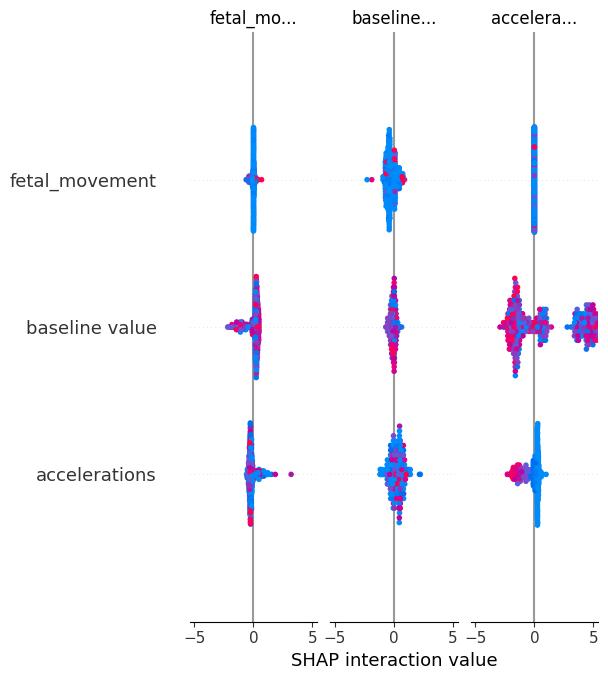

In [6]:
import shap
explainer = shap.TreeExplainer(models['XGBoost'])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


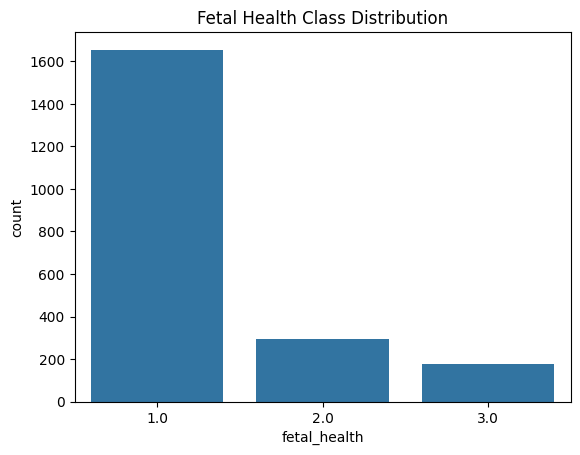

In [7]:
import seaborn as sns
sns.countplot(x='fetal_health', data=df)
plt.title('Fetal Health Class Distribution')
plt.show()


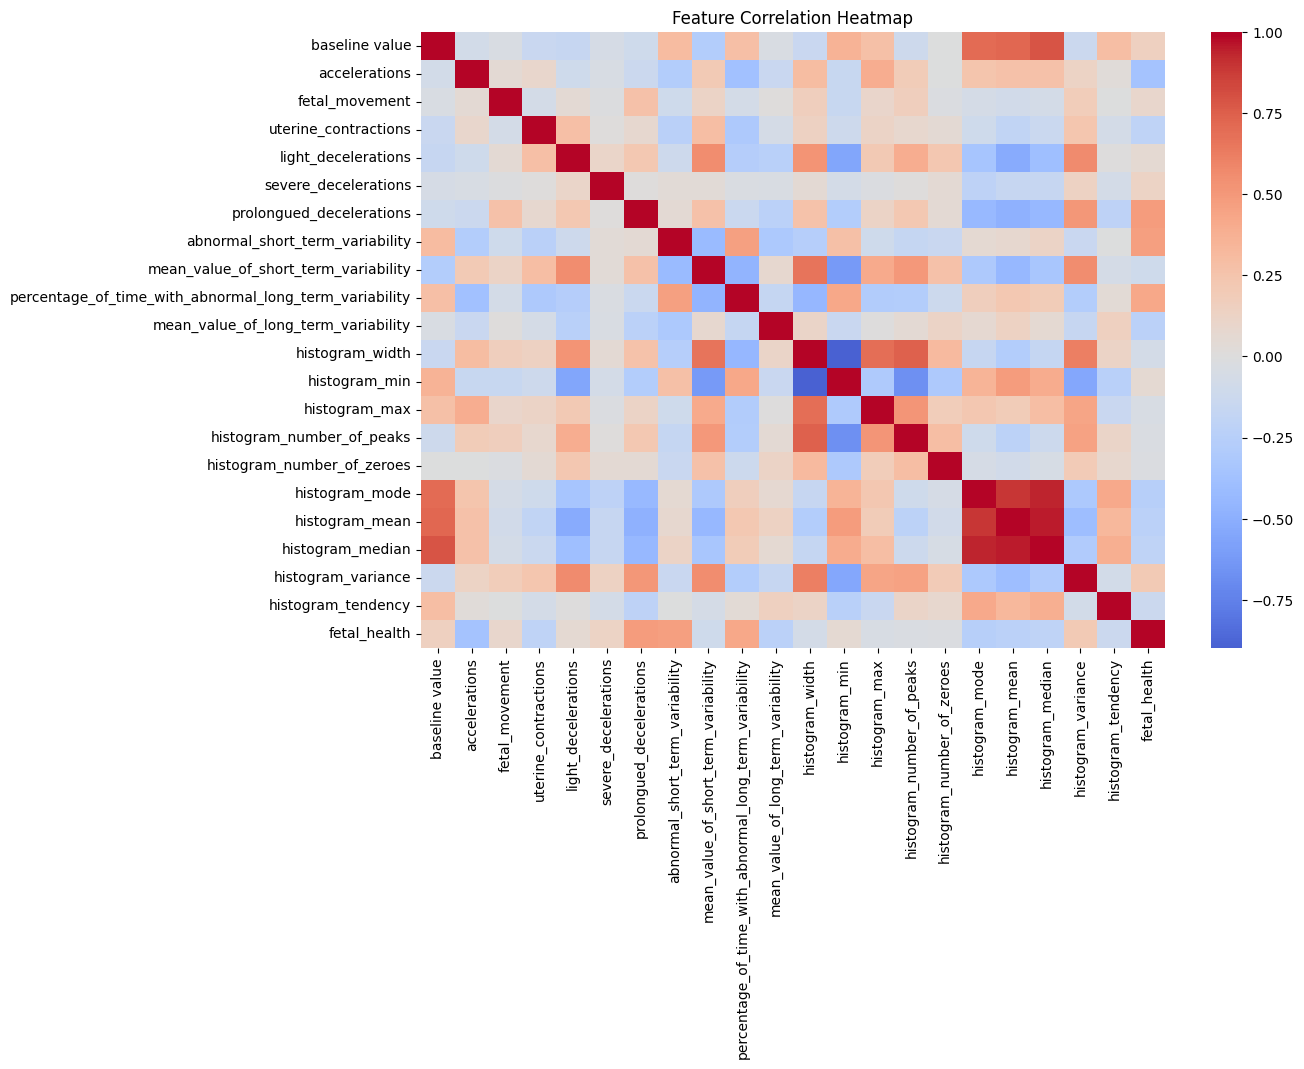

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


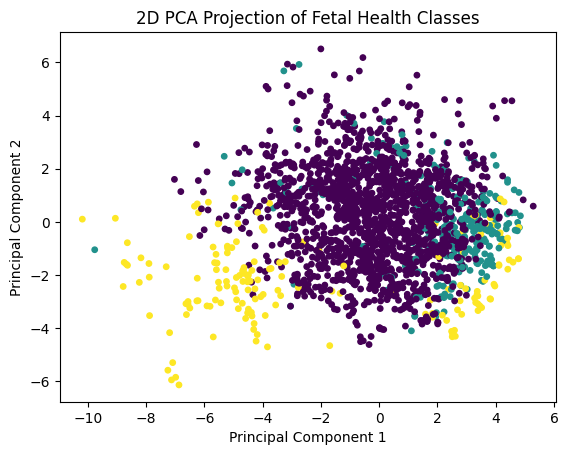

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', s=15)
plt.title("2D PCA Projection of Fetal Health Classes")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
